# Abraia - Getting started with image classification

In [1]:
%%capture
!python -m pip install abraia
!python -m pip install wget

import os
if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

from abraia import Abraia
 
abraia = Abraia()

# Cats and Dogs transfer learning

## Data preparation

Download the cats and dogs dataset and split some data for testing and validation.

In [15]:
import wget
import zipfile
from glob import glob

def load_dataset(dataset='cats-and-dogs'):
    if not os.path.exists('datasets'):
        os.mkdir('datasets')
    if dataset == 'cats-and-dogs':
        zip_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
        zip_file = 'datasets/kagglecatsanddogs_3367a.zip'
        if not os.path.exists('datasets/kagglecatsanddogs_3367a.zip'):
            wget.download(zip_url, zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('datasets/')
        class_names = ['Cat', 'Dog']
        return class_names

labels = load_dataset()
cat_paths = glob('datasets/PetImages/Cat/*.jpg')
dog_paths = glob('datasets/PetImages/Dog/*.jpg')

['Cat', 'Dog']

Plot some random images from the dataset.

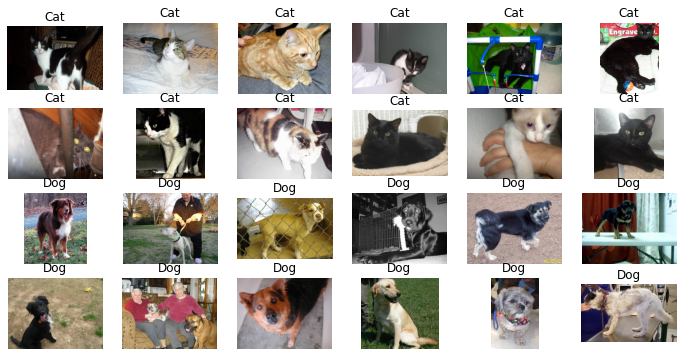

In [17]:
import numpy as np
import matplotlib.pyplot as plt

cats = np.random.choice(cat_paths, 12)
dogs = np.random.choice(dog_paths, 12)
data = np.concatenate((cats, dogs))
labels = 12 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 4, 6
plt.figure(figsize=(12, 6))
for k, (src, label) in enumerate(zip(data, labels)):
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(plt.imread(src))
    plt.axis('off')

In [16]:
import shutil
from sklearn.model_selection import train_test_split

cats_train, cats_test = train_test_split(cat_paths, test_size=0.30)
dogs_train, dogs_test = train_test_split(dog_paths, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)

if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)

!mkdir train/Cat
for cat_train in cats_train:
    shutil.move(cat_train, 'train/Cat')

!mkdir train/Dog
for dog_train in dogs_train:
    shutil.move(dog_train, 'train/Dog')

!mkdir test/Cat
for cat_test in cats_test:
    shutil.move(cat_test, 'test/Cat')

!mkdir test/Dog
for dog_test in dogs_test:
    shutil.move(dog_test, 'test/Dog')

## Model customization

In [18]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import load_model

def create_model(CLASSES=2):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = Dropout(0.4)(x)
    predictions = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(
        optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, validation_generator, EPOCHS=5, STEPS_PER_EPOCH=320, VALIDATION_STEPS=64):
    history = model.fit(
        train_generator, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_generator, validation_steps=VALIDATION_STEPS)
    return history

def predict_model(model, img):
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

def plot_train_history(history):
    plt.ylim(0, 1.01)
    plt.grid()
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training loss','Test accuracy'], loc='upper right')

## Data augmentation

In [19]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (299, 299)
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


Plot some images result of data augmentation.

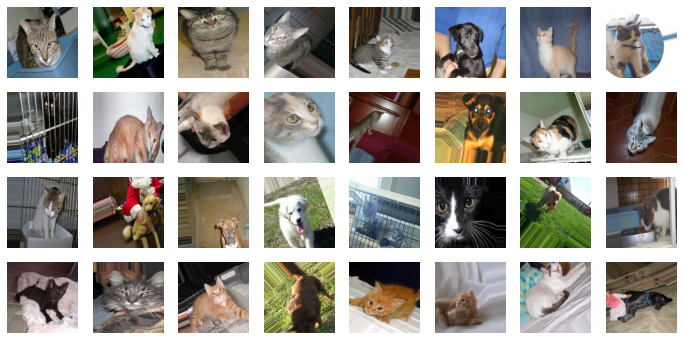

In [20]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [ ]:
MODEL_FILE = 'filename.model'

model = create_model()
history = train_model(model, train_generator, validation_generator)
model.save(MODEL_FILE)

plot_train_history(history)

## Prediction of the custom model

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_preds(img, preds, labels):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
model = load_model(MODEL_FILE)

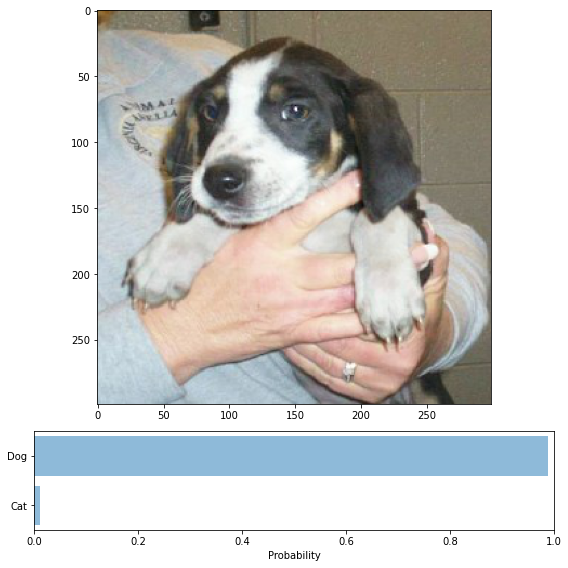

In [36]:
img = np.asarray(image.load_img('test/Dog/10.jpg', target_size=target_size))
preds = predict_model(model, img)

plot_preds(img, preds, labels)